In [1]:
import pandas as pd
from os import path
import numpy as np
import seaborn as sns

import_directory = "synData6July"
lotti_fn = "export_lotti_veneto_2016_2018_giulio_v2.csv"
vincitori_fn = "export_vincitori_veneto_2016_2018_giulio_v2.csv"
output_directory = "datasets"

pd.set_eng_float_format(accuracy=2, use_eng_prefix=True)

YEARS = [2016, 2017, 2018]

def replace_missing_value(df, col, replacement_col):
    mask = df[replacement_col].notna() & df[col].isna()
    df.loc[df[mask].index, col] = df[replacement_col][mask]
    return df

lotti = pd.read_csv(
        path.join(import_directory, lotti_fn))
vincitori = pd.read_csv(
        path.join(import_directory, vincitori_fn))

# convert datatypes
lotti.data_inizio = pd.to_datetime(lotti.data_inizio, yearfirst=True)
lotti.data_fine = pd.to_datetime(lotti.data_fine, yearfirst=True)
lotti.data_inferita = pd.to_datetime(lotti.data_inferita, yearfirst=True)

# replace missing values in col1 with values from col2
# lotti = replace_missing_value(lotti, "importo", "importo_base_asta")
lotti = replace_missing_value(lotti, "data_inizio", "data_inferita")

# keep only the relevant features
relevant_features = [
        "id_lotto", "importo", "id_pa", "data_inizio", "data_fine", 
        "id_scelta_contraente", "cpv"
]
lotti = lotti[relevant_features]
lotti = lotti.dropna()

relevant_features = ['id_lotto', 'id_be']
vincitori = vincitori[relevant_features]
vincitori = vincitori.dropna()

lotti.id_scelta_contraente = lotti.id_scelta_contraente.astype('int')
lotti.cpv = lotti.cpv.astype('int')

# voglio che solo i lotti a cui sia stato assegnato un vincitore siano presenti
df = vincitori.merge(lotti, on="id_lotto", how="left")
# numero di vincitori per lotto (contracting parties)
party = vincitori.groupby("id_lotto").size().rename("party")
df = df.merge(party, on="id_lotto", how="left")
# dividi l'importo per il numero di parti contraenti
df.loc[:, "importo"] = df.importo / df.party
# CONSIDER ONLY THE ROWS THAT HAVE CPV AND PROCEDURE 
df = df[df.cpv.notna()]
df = df[df.id_scelta_contraente.notna()]

In [3]:
lotti = pd.read_csv(
        path.join(import_directory, lotti_fn))
lotti.shape

(1382247, 16)

In [26]:
dataframe = dict()
for year in YEARS:
    t = df[df.data_inizio.dt.year == year]
    n_lots = t.groupby("id_be").size().rename("n_lots")
    t = t.merge(n_lots, on="id_be", how="left")
    dataframe[year] = t

df = pd.concat(list(dataframe[year] for year in YEARS), ignore_index=True)

In [27]:
# il numero di contratti con PA dipende dalla dimensione dell'impresa?
# posso davvero conoscerlo con i dati che ho?

# scatterplot number of contracts, revenue

def extract_med_rev_by_year(df, agent):
    rev_by_year = df.groupby([agent, df.data_inizio.dt.year]).sum().importo
    rev_by_year = rev_by_year.unstack()
    med_yearly_rev = rev_by_year.median(axis=1)
    if agent == "id_pa":
        med_yearly_rev = med_yearly_rev.rename("median_annual_expenditure")
    else:
        med_yearly_rev = med_yearly_rev.rename("median_annual_revenue")
    return df.join(med_yearly_rev, on=agent)

df = extract_med_rev_by_year(df, "id_be")
df = extract_med_rev_by_year(df, "id_pa")

In [28]:
t = df[~df[["n_lots", "median_annual_revenue"]].duplicated()]

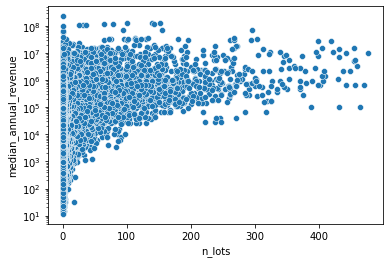

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.scatterplot(data=t[(t.n_lots < 500) & (t.median_annual_revenue > 10)], x="n_lots", y="median_annual_revenue")
plt.yscale("log")

In [30]:
t = df.groupby([df.data_inizio.dt.year, df.id_be]).size().rename("n_lots")


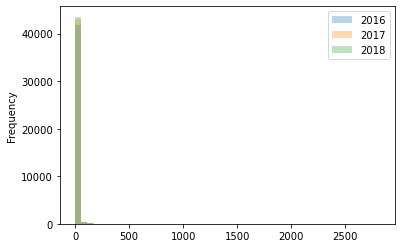

In [31]:
for i, year in enumerate(YEARS):
    t[year].plot.hist(bins=50, alpha=.3, label=year)
plt.legend()
plt.show()

50 contracts s.t. perc >= 35.73 in 2016
50 contracts s.t. perc >= 35.01 in 2017
50 contracts s.t. perc >= 38.34 in 2018


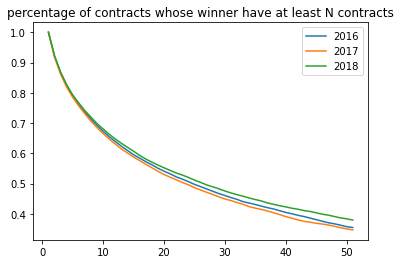

In [32]:
N = 50
NSIZE = N + 1
x = np.arange(1, NSIZE+1)
for year in YEARS:
    y = np.zeros(x.size)
    for i, n in enumerate(x):
        perc = sum(t[year][t[year] >= n]) / sum(t[year])
        y[i] = perc
    plt.plot(x, y, label=year)
    print(f"{N} contracts s.t. perc >= {y[N-1] * 100:.2f} in {year}")
plt.legend()
plt.title("percentage of contracts whose winner have at least N contracts")
plt.show()

ma si massimizza il numero di aziende o di contratti? coincidono le cose? No, 
ci sono poche aziende che chiudono moltissimi contratti

lost be perc 98.29, N:50, year 2016
lost be perc 98.33, N:50, year 2017
lost be perc 98.19, N:50, year 2018


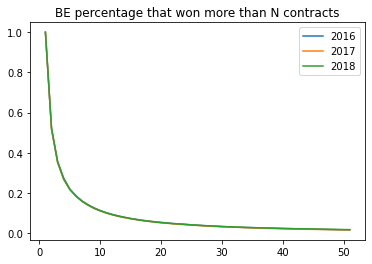

In [33]:
for i, year in enumerate(YEARS):
    y = np.zeros(x.size)
    for i, n in enumerate(x):
        perc = sum(t[year] >= n) / len(t[year])
        y[i] = perc
    plt.plot(x, y, label=year)
    print(f"lost be perc {(1 - y[N-1]) * 100 :.2f}, N:{N}, year {year}")
plt.legend()
plt.title("BE percentage that won more than N contracts")
plt.show()

In [34]:
# scompongo il dataset per anno.
# per ogni anno, seleziono solo quei vincitori che hanno più di N=7 contratti
dataframe = dict()
for year in YEARS:
    t = df[df.data_inizio.dt.year == year]
    dataframe[year] = t[t.n_lots > N]

df = pd.concat(list(dataframe[year] for year in YEARS), ignore_index=True)

category within 0.8 - ROW COUNT
cpv
33.00    61541
9.00      3321
65.00     2324
55.00     3406
dtype: int64


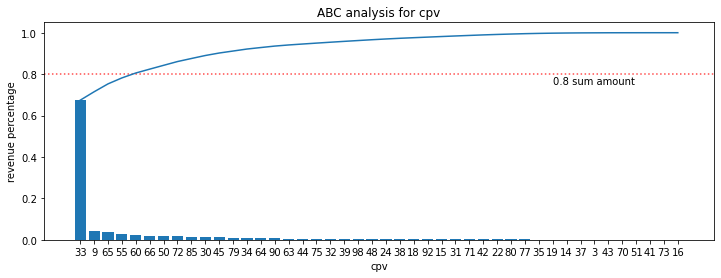

In [35]:
# ABC ANALYSIS
def plot_abc_items(df, category, ax, percentage):
    aggregate = df.groupby(category).importo.sum().sort_values(ascending=False)
    values = (aggregate / aggregate.sum()).values
    labels = np.array([int(i) for i in aggregate.index])
    idx = list(range(len(values)))
    ax.axhline(percentage, c="red", ls="dotted", alpha=.7)
    ax.text(x=idx[-10], y=(percentage - .05), s=f"{percentage} sum amount")
    ax.bar(idx, values)
    ax.plot(np.cumsum(values))
    ax.set_xticks(idx, labels)
    ax.set_xlabel(category)
    ax.set_ylabel("revenue percentage")
    ax.set_title(f"ABC analysis for {category}")
    count_aggregate = df.groupby(category).size()
    items = labels[np.cumsum(values) <= percentage]
    print(f"category within {percentage} - ROW COUNT")
    print(count_aggregate.loc[items])
    return items

fig, ax = plt.subplots(figsize=(6*2, 4))
abc_cpv = plot_abc_items(df, "cpv", ax, .8)

category within 0.94 - ROW COUNT
id_scelta_contraente
26.00     21332
4.00      12144
23.00    211138
1.00       1798
dtype: int64


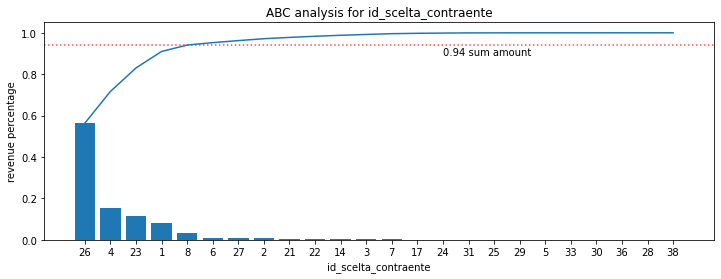

In [36]:
fig, ax = plt.subplots(figsize=(6*2, 4))
abc_procedures = plot_abc_items(df, "id_scelta_contraente", ax, .94)

In [37]:
# keep only the cpv and procedures
mask = (df.cpv == 33) & (df.id_scelta_contraente == 1)
count = 1
for cpv in abc_cpv:
    for procedure in abc_procedures:
        mask += (df.cpv == cpv) & (df.id_scelta_contraente == procedure)

df = df[mask]


In [38]:
# compute the  other features
def encode_sin_cos(df, period="DayOfYear"):
    if period == "month":
        x = df.data_inizio.dt.month
        period_items = 12
    x = df.data_inizio.dt.day_of_year
    period_items = 365
    df["sin" + period] = np.sin(x / period_items * 2 * np.pi)
    df["cos" + period] = np.cos(x / period_items * 2 * np.pi)
    return df

df['duration'] = (df.data_fine - df.data_inizio).dt.days
df = df.drop(columns=["data_fine"])

df = encode_sin_cos(df, "DayOfYear")

base_date = df.data_inizio.min()
df["daysSinceBaseDate"] = (df.data_inizio - base_date).dt.days
df = df.drop(columns=["data_inizio"])

df = df.drop(columns=["id_be", "id_pa"])


OUTLIER RULES

In [39]:
lotti = pd.read_csv(path.join(import_directory, lotti_fn), index_col="id_lotto")

In [40]:
rule1 = (df.median_annual_expenditure < df.importo) & (df.median_annual_revenue < df.importo)
df[rule1]

,id_lotto,importo,id_scelta_contraente,cpv,party,n_lots,median_annual_revenue,median_annual_expenditure,duration,sinDayOfYear,cosDayOfYear,daysSinceBaseDate
38955,18406503,117.78M,26.00,33.00,1,455,15.03M,3.67M,1003,17.21m,999.85m,0


In [41]:
for item in df[rule1].id_lotto.values:
    row = lotti.loc[item]
    print(row.data_inizio, row.oggetto)
    print()

2016-01-01 G.R. SUTURATRICI MECC., CLIPS E SISTEMI FISS. - QUOTA ULSS 7 - LOTTO N. 8 SUTURATRICI CIRCOLARI CURVE, MONOUSO, CON TESTINA STACCABILE NON BASCULANTE E BISTURI INCORPORATO; DOPPIA FILA CIRCOLARE DI PUNTI SFALSATI COMPATIBILI CON RNM FINO A 3 TESLA; SISTEMA DI SICUREZZA E CODICE COLORE. ALMENO 4 MISURE DIFFERENTI NEL DIAMETRO DELLA TESTINA.



su contrattipubblici.org non compare. Davide dice che non posso assumere niente


In [42]:
rule2 = df.importo > 100 * df.median_annual_expenditure
df[rule2]

,id_lotto,importo,id_scelta_contraente,cpv,party,n_lots,median_annual_revenue,median_annual_expenditure,duration,sinDayOfYear,cosDayOfYear,daysSinceBaseDate


In [43]:
for item in df[rule2].id_lotto.values:
    row = lotti.loc[item]
    print(row.data_inizio, row.importo,  row.id_pa, row.oggetto)
    print()

onestamente queste median annual expenditure sono strane

In [44]:
rule3 = df.importo > 25 * df.median_annual_revenue
df[rule3]

,id_lotto,importo,id_scelta_contraente,cpv,party,n_lots,median_annual_revenue,median_annual_expenditure,duration,sinDayOfYear,cosDayOfYear,daysSinceBaseDate
245038,19005684,15.69M,26.00,33.00,1,209,625.39k,170.87M,688,329.41m,-944.19m,893


In [45]:
for item in df[rule3].id_lotto.values:
    row = lotti.loc[item]
    print(row.data_inizio, row.importo, row.importo_base_asta, row.oggetto)
    print()

2018-06-12 15685176.0 nan GARA REGIONALE FARMACI - DETERMINA 982/2018 - LOTTO 401



nell'originale questo lotto non ha l'importo, ha solo l'importo base d'asta, che invece in questo caso è nan. In ogni caso non è un outliers